### ARIMA(p, d, q) models with Seasonality

This notebook will go over how to fit ARIMA models that have a seasonal term, such as the airline passengers data that we saw previously.

In [2]:
# first, we pull in the data
import pandas as pd
df = pd.read_csv('../data/AirPassengers.csv', index_col='Month', parse_dates=True)

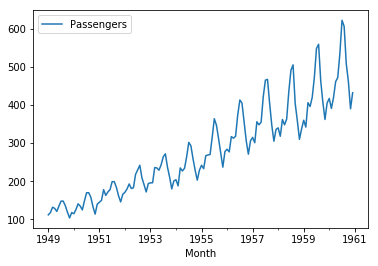

In [3]:
# clearly there is a non-random oscillating seasonal component to the data
%matplotlib inline
df.plot();

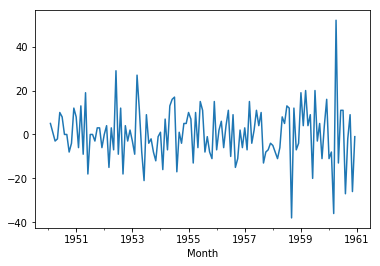

In [9]:
# we saw previously how adding a seasonal differencing term did a lot to remove the trend from the data
df.Passengers.diff().diff(periods=12).plot();

we also saw how, previously, we would find the value for AR(p) and MA(q) using the plots for autocorrelation and partial autocorrelation, which we can see below.

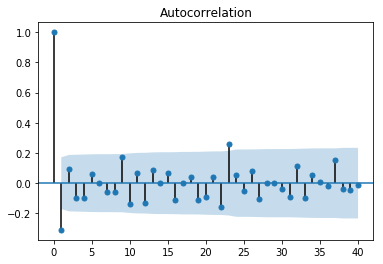

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary_data = df['Passengers'].diff().diff(periods=12)[13:]
x = plot_acf(stationary_data, lags=40)

Looking at the above chart, we can see that we definitely have one significant autocorrelation at lag 1, and *possibly* another around lag 26.

If we look at the partial autocorrelation, we see a slightly different story:

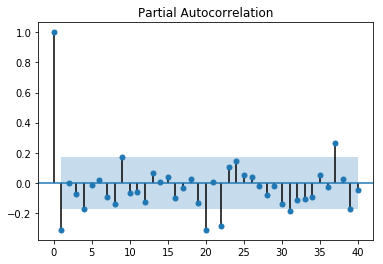

In [27]:
x = plot_pacf(stationary_data, lags=40)

Here we are seeing signs of the seasonality we encountered when we looked at the original plot.  A significant lag that routinely shows up every n number of lags shows up as a value of 1 when using it for a value of p or q.

Since these spikes occur using our autocorrelation plot, we'll infer that our *seasonal* autoregressive term is 1.

To recap:

 - From our original model we have values for *p*, *d*, and *q* as 1, respectively.
 - We have a seasonal differencing term, since using a seasonal lag of 12 gave us the most stationary time series.
 - Our autocorrelation plot *did not* suggest a season moving average term.
 - Our partial autocorrelation plot *did* suggest a season autoregressive part, with the expected significant lag occurring ~ every 12 lags.
 
Our *seasonal* model would be denoted SARIMA(p, d, q, P, D, Q, period).  The 'S' standing for 'Seasonal', and the terms 'P', 'D', and 'Q', standing for the seasonal portions of our model, respectively.  The period is the interval in steps we're using for our seasonal term.

So in our case, we have a hypothetical model of SARIMA(1, 1, 1, 1, 1, 0, 12).

### Fitting SARIMA models in Statsmodels

You use a slightly different module for SARIMA models in statsmodels.  

In [37]:
# import the model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit it using our derived terms
mod = SARIMAX(df['Passengers'], order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))

# fit the model
results = mod.fit()

C:\Users\Jonat\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [38]:
# and now we'll print our results
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -507.178
Date:                            Mon, 26 Aug 2019   AIC                           1022.356
Time:                                    15:27:05   BIC                           1033.857
Sample:                                01-01-1949   HQIC                          1027.029
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2160      0.392     -0.551      0.582      -0.985       0.553
ma.L1         -0.0875      0.370   

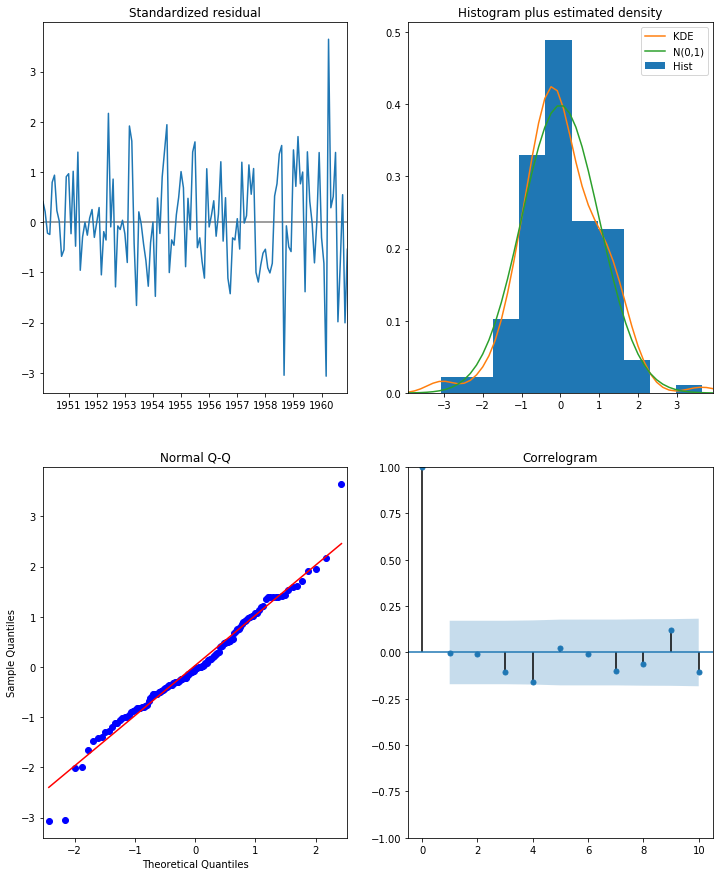

In [42]:
# and finally, we'll go ahead and plot diagnostics on our residuals
x = results.plot_diagnostics(figsize=(12, 15))

In [43]:
# and we'll also look at our error metric
results.aic

1022.3557767681788

In [47]:
# and finally get a forecast from our previous results
results.forecast(6)

1961-01-01    445.833826
1961-02-01    420.909276
1961-03-01    454.027735
1961-04-01    488.650103
1961-05-01    501.494417
1961-06-01    562.934219
Freq: MS, dtype: float64

In [79]:
# and get the confidence interval
results.get_prediction(start='1961-01-01', end='1961-06-01', dynamic=False).conf_int()

,lower Passengers,upper Passengers
1961-01-01,423.090287,468.577365
1961-02-01,393.193586,448.624967
1961-03-01,421.339387,486.716083
1961-04-01,451.801355,525.498850
1961-05-01,460.880311,542.108523
1961-06-01,518.881211,606.987227


In [82]:
df.diff().diff(periods=12).describe()

,Passengers
count,131.000000
mean,0.183206
std,12.356749
min,-38.000000
25%,-7.500000
50%,0.000000
75%,9.000000
max,52.000000
